Total races with exactly one Max teammate: 149


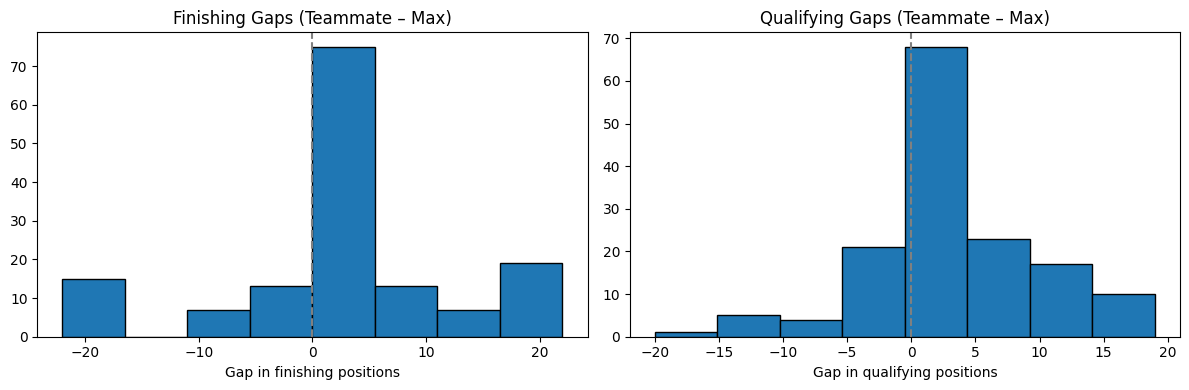

Posterior mean μ ≈ 2.60
95% CI for μ: [0.90, 4.29]
P(μ > 0) ≈ 0.999


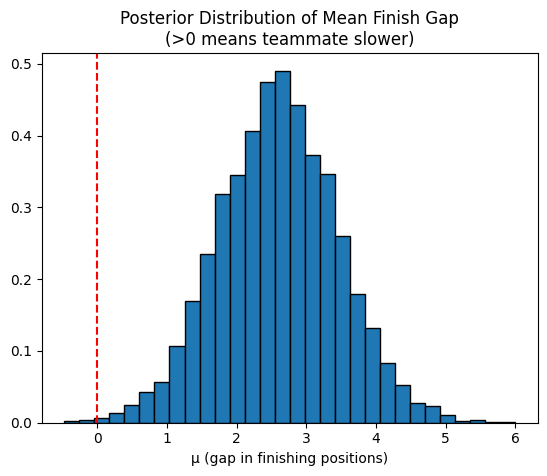


Qualifying μ ≈ 3.53
95% CI: [2.46, 4.62]
P(μ > 0) ≈ 1.000


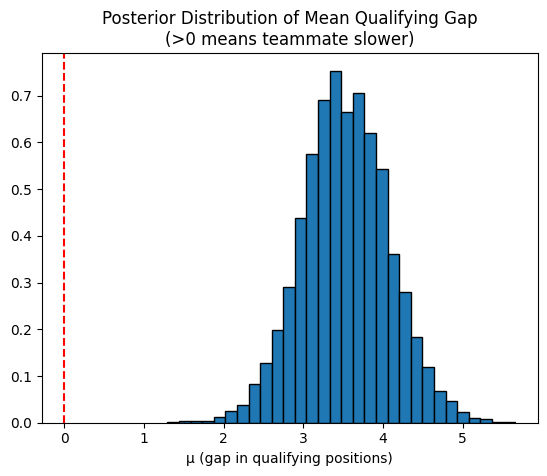

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, norm

df = pd.read_csv("ALLTEAMSQvFDetail2016.csv")
df = df.rename(columns={
    'gridPos': 'qualifying_position',
    'raceResult': 'finishing_position'
})
df['finishing_position'] = pd.to_numeric(df['finishing_position'], errors='coerce')
max_finish = int(df['finishing_position'].max(skipna=True))
df['finishing_position'] = df['finishing_position'].fillna(max_finish + 1)
df['qualifying_position'] = pd.to_numeric(df['qualifying_position'], errors='coerce')

rb = df[df['Team'].str.contains('Red Bull', case=False, na=False)].copy()

records = []
for (year, race), group in rb.groupby(['Year','raceName']):
    drivers = group['Driver'].unique()
    if 'Max Verstappen' in drivers and len(drivers) == 2:
        sub = group.set_index('Driver')
        q_max = sub.at['Max Verstappen','qualifying_position']
        f_max = sub.at['Max Verstappen','finishing_position']
        mate = [d for d in drivers if d != 'Max Verstappen'][0]
        q_m  = sub.at[mate,'qualifying_position']
        f_m  = sub.at[mate,'finishing_position']
        records.append({
            'Year': year,
            'raceName': race,
            'teammate': mate,
            'qual_gap': q_m  - q_max,
            'finish_gap': f_m - f_max
        })

gaps = pd.DataFrame(records)
print(f"Total races with exactly one Max teammate: {len(gaps)}")

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(gaps['finish_gap'], bins=8, edgecolor='k')
axes[0].axvline(0, color='grey', linestyle='--')
axes[0].set_title('Finishing Gaps (Teammate – Max)')
axes[0].set_xlabel('Gap in finishing positions')

axes[1].hist(gaps['qual_gap'], bins=8, edgecolor='k')
axes[1].axvline(0, color='grey', linestyle='--')
axes[1].set_title('Qualifying Gaps (Teammate – Max)')
axes[1].set_xlabel('Gap in qualifying positions')

plt.tight_layout()
plt.show()

x = gaps['finish_gap'].values
n = x.size
xbar = x.mean()
S = np.sum((x - xbar)**2)
mu0, kappa0 = 0.0, 1e-2
alpha0, beta0 = 1e-2, 1e-2

kappa_n = kappa0 + n
mu_n    = (kappa0*mu0 + n*xbar) / kappa_n
alpha_n = alpha0 + n/2
beta_n  = beta0 + 0.5*S + (kappa0*n*(xbar - mu0)**2)/(2*kappa_n)

nsamps = 5000
sig2_samps = invgamma.rvs(a=alpha_n, scale=beta_n, size=nsamps)
mu_samps   = norm.rvs(loc=mu_n, scale=np.sqrt(sig2_samps/kappa_n))

p_gt0 = np.mean(mu_samps > 0)
ci_lower, ci_upper = np.percentile(mu_samps, [2.5, 97.5])
print(f"Posterior mean μ ≈ {mu_samps.mean():.2f}")
print(f"95% CI for μ: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"P(μ > 0) ≈ {p_gt0:.3f}")

plt.hist(mu_samps, bins=30, density=True, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.title('Posterior Distribution of Mean Finish Gap\n(>0 means teammate slower)')
plt.xlabel('μ (gap in finishing positions)')
plt.show()

y = gaps['qual_gap'].values
n2 = y.size
ybar = y.mean()
S2 = np.sum((y - ybar)**2)

kappa2 = kappa0 + n2
mu2    = (kappa0*mu0 + n2*ybar) / kappa2
alpha2 = alpha0 + n2/2
beta2  = beta0 + 0.5*S2 + (kappa0*n2*(ybar - mu0)**2)/(2*kappa2)

sig2_q  = invgamma.rvs(a=alpha2, scale=beta2, size=nsamps)
mu_q    = norm.rvs(loc=mu2, scale=np.sqrt(sig2_q/kappa2))

p2_gt0 = np.mean(mu_q > 0)
ci2_l, ci2_u = np.percentile(mu_q, [2.5, 97.5])
print(f"\nQualifying μ ≈ {mu_q.mean():.2f}")
print(f"95% CI: [{ci2_l:.2f}, {ci2_u:.2f}]")
print(f"P(μ > 0) ≈ {p2_gt0:.3f}")

plt.hist(mu_q, bins=30, density=True, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.title('Posterior Distribution of Mean Qualifying Gap\n(>0 means teammate slower)')
plt.xlabel('μ (gap in qualifying positions)')
plt.show()